In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

from tensorflow import keras
from keras import models, layers, optimizers, callbacks

In [2]:
import datetime
from datetime import datetime, date, timedelta
import math
import canada_holiday
from pyhelpers.store import save_fig, save_svg_as_emf
import subprocess
import  aspose.cells 
from aspose.cells import Workbook

# Preprocessing Data

In [5]:
fsa_chosen = "L9G"
years = ['2018', '2019', '2020', '2021', '2022', '2023']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# Setting up paths for data loading
dirs_x_y_input = os.path.join("..", "data", "X_Y_Inputs")
file_path_x = os.path.join(dirs_x_y_input, "X_df_"+fsa_chosen+".csv")
file_path_y = os.path.join(dirs_x_y_input, "Y_df_"+fsa_chosen+".csv")

# Load the data
X_df_cnn = pd.read_csv(file_path_x)
Y_df_cnn = pd.read_csv(file_path_y)

# Drop unrequired columns
drop_list = [
    "Rel Hum (%)",
    "Wind Spd (km/h)",
    #"DATE",
]
feature_columns = X_df_cnn.columns.to_list()
for col in drop_list:
    feature_columns.remove(col)

# Create dataframe without humidity and speed
data = X_df_cnn[feature_columns]

This code block is identical to the one above except for the file. This uses the normalized X_df.

In [5]:
fsa_chosen = "L9G"
years = ['2018', '2019', '2020', '2021', '2022', '2023']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# Setting up paths for data loading
dirs_x_y_input = os.path.join("..", "data", "X_Y_Inputs")
file_path_x = os.path.join(dirs_x_y_input, "X_df_normalized.csv")
file_path_y = os.path.join(dirs_x_y_input, "Y_df_"+fsa_chosen+".csv")

# Load the data
X_df_cnn = pd.read_csv(file_path_x)
Y_df_cnn = pd.read_csv(file_path_y)

# Drop unrequired columns
drop_list = [
    "Rel Hum (%)",
    "Wind Spd (km/h)",
    #"DATE",
]
feature_columns = X_df_cnn.columns.to_list()
for col in drop_list:
    feature_columns.remove(col)

# Create dataframe without humidity and speed
data = X_df_cnn[feature_columns]

In [6]:
window_size = 168  # Last 168 hours (one week)
forecast_horizon = 24  # Next 24 hours

X_data = []
y_data = []

# Create input-output pairs using a sliding window
for i in range(len(data) - window_size - forecast_horizon + 1):
    X_data.append(data.iloc[i:i + window_size + forecast_horizon].values)  # Collect 168 hours of feature data
    # Collect the next 24 hours of output data from Y_df
    y_data.append(Y_df_cnn.iloc[i + window_size:i + window_size + forecast_horizon].values.flatten())  # Flatten to ensure it's 1D

# Convert to numpy arrays
X_data, y_data = np.array(X_data, dtype=np.float32), np.array(y_data, dtype=np.float32)
X_data = np.expand_dims(X_data, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False, random_state=42)

# Set up the model structure

In [20]:
# Better model
model = models.Sequential(
    [
        layers.Input(shape=X_train.shape[-3:]),
        layers.Conv2D(
            filters=32, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.MaxPool2D(
            pool_size=(1, 2)
        ),  # Keep the width the same size, pool the height
        layers.Conv2D(
            filters=64, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.MaxPool2D(pool_size=(1, 2)),
        layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        layers.MaxPool2D(pool_size=(1, 2)),
        layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        # Flatten the layers to feed into dense network
        layers.Flatten(),
        # Add dense layers
        layers.Dense(128, activation="relu"),
        layers.Dense(
            24
        ),  # This is the output layer, we are predicting 24 hours!!!
    ]
)

# Customizing the Adam optimizer
optimizer = optimizers.Adam(
    # learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07
)

# Compile the model
model.compile(optimizer=optimizer, loss=keras.losses.Huber(), metrics=["mae"])

# Train the model (with early stopping)

In [21]:
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",  # Metric to monitor
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
)

Epoch 1/5
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 591s 562ms/step - loss: 2226.8113 - mae: 2227.3113 - val_loss: 1175.5074 - val_mae: 1176.0074
Epoch 2/5
 310/1048 ━━━━━━━━━━━━━━━━━━━━ 6:40 543ms/step - loss: 1052.2664 - mae: 1052.7662

KeyboardInterrupt: 

# Save the Model

In [14]:
model_dir = os.path.join("..", "models", "cnn_best_model.keras")
model.save(model_dir)

# Cool Prediction stuff

In [15]:
# Make predictions
model_dir = os.path.join("..", "models", "cnn_best_model.keras")
model = models.load_model(model_dir)

Y_pred = model.predict(X_test)  # Predict on X_test

# Convert predictions to a DataFrame
Y_pred_df = pd.DataFrame(Y_pred)

328/328 ━━━━━━━━━━━━━━━━━━━━ 50s 152ms/step


# Cool Plotting Stuff that needs History

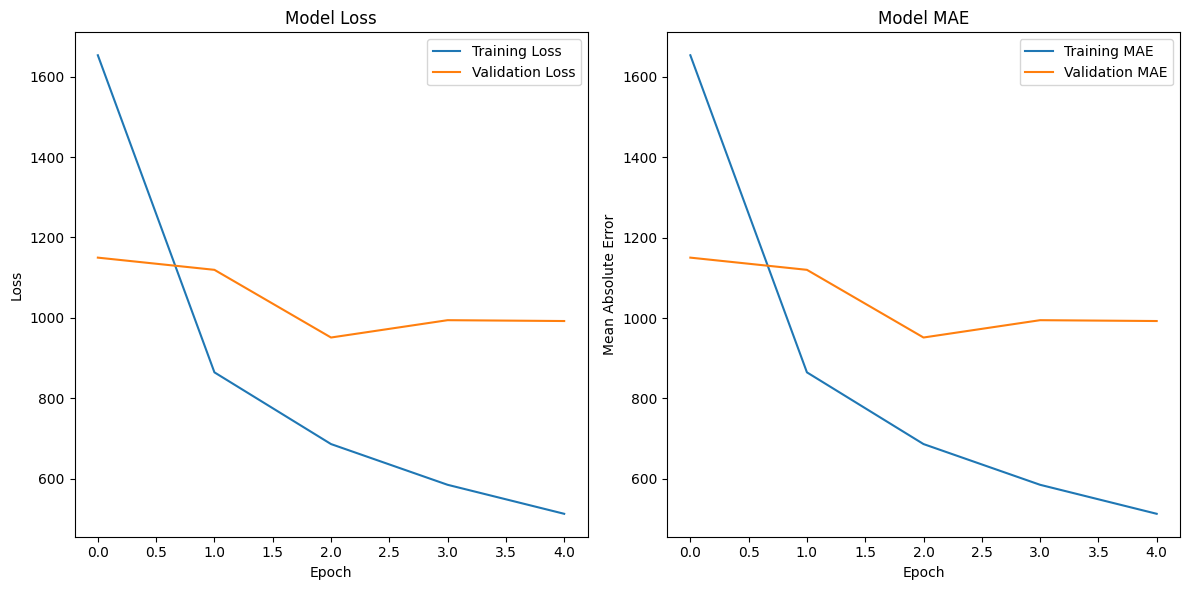

In [16]:

# Extract loss and MAE values from the history object
loss = history.history['loss']
mae = history.history['mae']
val_loss = history.history['val_loss']  # Validation loss
val_mae = history.history['val_mae']    # Validation MAE

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for MAE
plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Model Evaluation

In [17]:
#Evaluate the model
print(f'##Model Evaluation##')
# X_test = np.expand_dims(X_test, axis=-1)
test_loss, test_mae = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)  # Use X_test and y_test
print(f'Test Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Function to calculate Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, Y_pred):
    y_true, Y_pred = np.array(y_true), np.array(Y_pred)
    return np.mean(np.abs((y_true - Y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, Y_pred)
print("MAPE = " + str(round(mape, 3)) + "%.")

##Model Evaluation##
328/328 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - loss: 2379.5425 - mae: 2380.0422
Test Loss: 1925.0885
Test MAE: 1925.5884
MAPE = 20.697%.


# Plotting

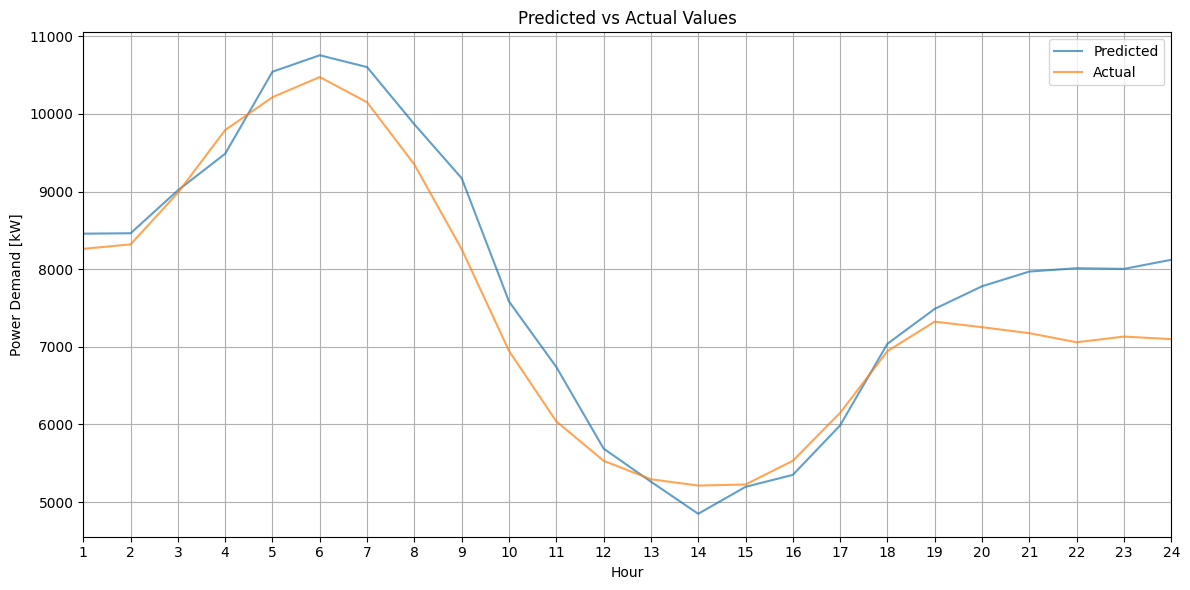

In [16]:
random_test_day = 75

# Create a simple plot comparing predictions vs actual values
plt.figure(figsize=(12, 6))
times = np.arange(1,25,1)
plt.plot(times, Y_pred[random_test_day], label='Predicted', alpha=0.7)
plt.plot(times, y_test[random_test_day], label='Actual', alpha=0.7)
plt.title('Predicted vs Actual Values')
plt.xlabel('Hour')
plt.ylabel('Power Demand [kW]')

plt.xlim(1, 24)
plt.xticks(np.arange(1, 25, 1))

plt.legend()
plt.grid(True)
plt.tight_layout()


In [21]:
print(data.columns.tolist())

['WEEKEND', 'SEASON', 'HOLIDAY', 'Temp (C)', 'Dew Point Temp (C)', 'WIND CHILL CALCULATION', '2018', '2019', '2020', '2021', '2022', '2023', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'DAY_1', 'DAY_2', 'DAY_3', 'DAY_4', 'DAY_5', 'DAY_6', 'DAY_7', 'DAY_8', 'DAY_9', 'DAY_10', 'DAY_11', 'DAY_12', 'DAY_13', 'DAY_14', 'DAY_15', 'DAY_16', 'DAY_17', 'DAY_18', 'DAY_19', 'DAY_20', 'DAY_21', 'DAY_22', 'DAY_23', 'DAY_24', 'DAY_25', 'DAY_26', 'DAY_27', 'DAY_28', 'DAY_29', 'DAY_30', 'DAY_31', 'HOUR_1', 'HOUR_2', 'HOUR_3', 'HOUR_4', 'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9', 'HOUR_10', 'HOUR_11', 'HOUR_12', 'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17', 'HOUR_18', 'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22', 'HOUR_23', 'HOUR_24']


The below doesn't work because "YEAR" isn't a colunmn in "data".

# Plotting Again (This one should work!)

In [17]:
# Set up information for selecting the target day
year = 2023
month = 4
day = 23
hour = 1

# Get first index of match
index = data[
    (data["YEAR"] == year)
    & (data["MONTH"] == month)
    & (data["DAY"] == day)
    & (data["HOUR"] == hour)
].index[0]

x_plot_df = pd.DataFrame()
y_plot_df = pd.DataFrame()

# Generate numpy arrays of data for predicting
if index < 168:
    print("Please select a later date and time, not enough data points!")
else:
    x_plot_df = data[index - 168 : index + 24]
    y_plot_df = Y_df_cnn[index : index + 24]

    x_plot_arr = x_plot_df.to_numpy()
    x_plot_arr = np.expand_dims(x_plot_arr, axis=-1)
    y_plot_arr = y_plot_df.to_numpy().flatten()

KeyError: 'YEAR'

In [19]:
# Load the model
model_dir = os.path.join("..", "models", "cnn_best_model.keras")
model = models.load_model(model_dir)

# Make a prediction, expand dims is called to ensure there is an axis for batch
# which is equal to 1 as prediction size is 1
y_plot_arr_pred = model.predict(np.expand_dims(x_plot_arr, axis=0))

NameError: name 'x_plot_arr' is not defined

In [18]:
# Define the time interval
times = np.arange(hour, hour + 24, 1)

# Create a simple plot comparing predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(times, y_plot_arr_pred[0], label="Predicted", alpha=0.7)
plt.plot(times, y_plot_arr, label="Actual", alpha=0.7)
plt.title(f"Comparison between Actual and Predicted Power Consumption on {day}/{month}/{year}")
plt.xlabel("Hour")
plt.ylabel("Power Consumption [kW]")

plt.xlim(hour, hour + 23)
plt.xticks(ticks=np.arange(hour, hour + 24, 1), labels=[(h - 1) % 24 + 1 for h in range(hour, hour + 24)])

plt.legend()
plt.grid(True)
plt.tight_layout()

NameError: name 'y_plot_arr_pred' is not defined

<Figure size 1000x500 with 0 Axes>